# Text Classification:  Quora questions pairs 
In this notebook we try our best to solve a Kaggle competition problem in which we are trying to answer the following question: Can you identify question pairs that have the same intent?

https://www.kaggle.com/c/quora-question-pairs

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## First look at the data

In [2]:
path = "/data/yinterian/quora-question-pairs/"

In [3]:
!head $path/train.csv

In [4]:
data = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## Initial Clean-up

In [6]:
import re
# see how ? is attached to the last word, need to make a space so that splitting on spaces will work
data.loc[0, 'question1']

'What is the step by step guide to invest in share market in india?'

In [7]:
def add_spaces_around_puctuation(question):
    return re.sub(r"\s?([^\w\s'/\-\+$]+)\s?", r" \1 ", str(question))

In [8]:
add_spaces_around_puctuation(data.loc[0, 'question1'])

'What is the step by step guide to invest in share market in india ? '

In [9]:
data["question1"] = data["question1"].apply(add_spaces_around_puctuation)
data["question2"] = data["question2"].apply(add_spaces_around_puctuation)

In [10]:
test["question1"] = test["question1"].apply(add_spaces_around_puctuation)
test["question2"] = test["question2"].apply(add_spaces_around_puctuation)

## Feature Analysis
Here we compute a measure of similarity between the two input questions.

In [11]:
# get stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yinterian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# modified from https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
def get_non_stopwords(question):
    """Returns a list of non-stopwords"""
    return {x:1 for x in str(question).lower().split() if x not in stops}.keys()
    
def jaccard_similarity(row):
    """ Return percent or shared words"""
    w1 = get_non_stopwords(row['question1'])
    w2 = get_non_stopwords(row['question2'])
    inter = set(w1).intersection(w2)
    union = set(w1).union(w2)
    return len(inter)/(len(union) + 0.00001)

In [13]:
row = data.iloc[0]
w1 = get_non_stopwords(row['question1'])
w2 = get_non_stopwords(row['question2'])
print(w1, w2, jaccard_similarity(row))

dict_keys(['step', 'guide', 'invest', 'share', 'market', 'india', '?']) dict_keys(['step', 'guide', 'invest', 'share', 'market', '?']) 0.8571416326548106


In [14]:
jaccard = data.apply(jaccard_similarity, axis=1, raw=True)

Text(0.5,0,'Jaccard similarity')

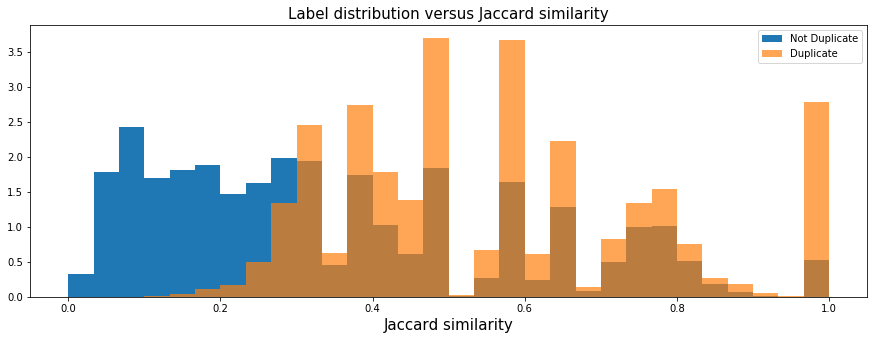

In [15]:
# plotting
plt.figure(figsize=(15, 5))
plt.hist(jaccard[data['is_duplicate'] == 0], bins=30, normed=True, label='Not Duplicate')
plt.hist(jaccard[data['is_duplicate'] == 1], bins=30, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution versus Jaccard similarity', fontsize=15)
plt.xlabel('Jaccard similarity', fontsize=15)

This looks like a very successful feature. But wait ... This is based on one-hot encoding of features. Can we do better with embeddings?

In [16]:
data["JS"] = jaccard
test["JS"] = test.apply(jaccard_similarity, axis=1, raw=True)

In [17]:
y_data = data['is_duplicate'].values

In [18]:
y_data.shape

(404290,)

## Creating a train and validation sets
The mean of the target value is different in the training data than in the public test set. If you submit a constant predition of 0.369 (mean of the training set) you get a loss of 0.554. What is the mean target of the public test set? This is very similar to a HW excercise. The solution is 0.174. Here we create a validation set with mean target value of 0.174

In [19]:
data.is_duplicate.mean()

0.369197853026293

We have a larger proportion of 1s in the training set than in the test set. A strategy that is often used in these cases is to oversample the 0s. First we split training data into train and val and then we oversample.

In [20]:
from sklearn.model_selection import train_test_split
train, val, y_train, y_val = train_test_split(data, y_data, test_size=0.2, random_state=23)

In [21]:
# how many negatives we need 
print(len(train), len(val)) 

323432 80858


In [22]:
neg_index = np.where(y_train == 0)[0]
neg_index_val = np.where(y_val == 0)[0]

In [23]:
# how many new rows a I need?
p = 0.174
p2 = (1-p)/p
new_train = int((len(train) - neg_index.shape[0])*p2 - neg_index.shape[0])
new_val = int((len(val) - neg_index_val.shape[0])*p2 - neg_index_val.shape[0])
print(new_train, new_val)

361418 92124


In [24]:
train_sample = train.iloc[neg_index].sample(n = new_train, replace = True)
val_sample = val.iloc[neg_index_val].sample(n = new_val, replace = True)

In [25]:
train_balanced = pd.concat((train, train_sample.copy()))
val_balanced = pd.concat((val, val_sample.copy()))

In [26]:
train_balanced["random"] = 1
val_balanced["random"] = 1
features = train_balanced.columns[[6,7]]

In [27]:
y_train = train_balanced["is_duplicate"].values
x_train = train_balanced[features].values
y_val = val_balanced["is_duplicate"].values
x_val = val_balanced[features].values

In [28]:
features

Index(['JS', 'random'], dtype='object')

## Training on one feature

In [31]:
import xgboost as xgb

xgb_pars = {"min_child_weight": 50, "eta": 0.05, "max_depth": 8,
            "subsample": 0.8, "silent" : 1, "nthread": 4,
            "eval_metric": "logloss", "objective": "binary:logistic"}

d_train = xgb.DMatrix(x_train, label=y_train)
d_val = xgb.DMatrix(x_val, label=y_val)

watchlist = [(d_train, 'train'), (d_val, 'valid')]

bst = xgb.train(xgb_pars, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=50)

[0]	train-logloss:0.645403	valid-logloss:0.645358
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.374559	valid-logloss:0.373966
[100]	train-logloss:0.372122	valid-logloss:0.371706
[150]	train-logloss:0.371488	valid-logloss:0.371145
[200]	train-logloss:0.371303	valid-logloss:0.371002
[250]	train-logloss:0.37122	valid-logloss:0.370962
[300]	train-logloss:0.371182	valid-logloss:0.370934
[350]	train-logloss:0.371149	valid-logloss:0.370921


## Creating Embedding features
You can get Globe embedings from https://nlp.stanford.edu/projects/glove/

In [32]:
globe_path = "/data/yinterian/Glove/glove.6B.50d.txt"

In [33]:
def load_word_embedings(file ="/data/yinterian/Glove/glove.6B.50d.txt"):
    embeddings = {}
    with open(file, 'r') as infile:
        for line in infile:
            values = line.split()
            embeddings[values[0]] = np.asarray(values[1:], dtype='float32')
    return embeddings

In [34]:
embeddings = load_word_embedings()

In [35]:
len(embeddings.keys())

400000

In [36]:
def sentence_features(s, embeddings=embeddings):
    words = get_non_stopwords(s)
    words = [w for w in words if w.isalpha() and w in embeddings]
    if len(words) == 0:
        return np.hstack([np.zeros(50), np.zeros(50), np.zeros(50)])
    M = [embeddings[w] for w in words]
    M = np.array(M)
    v_mean = M.mean(axis=0)
    v_min = M.min(axis=0)
    v_max = M.max(axis=0)
    return np.hstack([v_mean,v_min, v_max])

In [49]:
def sentence_features_v2(s, embeddings=embeddings):
    words = get_non_stopwords(s)
    words = [w for w in words if w.isalpha() and w in embeddings]
    if len(words) == 0:
        return np.hstack([np.zeros(50)])
    M = np.array([embeddings[w] for w in words])
    return M.mean(axis=0)

In [37]:
w = sentence_features(data.loc[0, "question1"])
w.shape

(150,)

In [38]:
train_balanced.head()

,id,qid1,qid2,question1,question2,is_duplicate,JS,random
83823,83823,141825,141826,How can I get rid of small mosquitos in kitche...,How can I get rid of tiny roaches in the kitch...,0,0.499999,1
145241,145241,86221,51226,What are the best books for UPSC ?,Which are the best books to prepare for IAS ex...,0,0.428571,1
238613,238613,350027,350028,Where can I get the second edition of Alan V ....,"How can I get a free link of a book called , ...",0,0.200000,1
382628,382628,88337,356439,Do women really like big penises ?,Do women prefer circumference or length in pen...,0,0.200000,1
256286,256286,371362,371363,Is the Russian Army IRP the same as the Urban ...,Does anyone watch Fubo TV and do they provide ...,0,0.062500,1


In [39]:
# create sentence vectors for question1
x_train_q1 = np.array([sentence_features_v2(x) for x in train_balanced["question1"].values])
x_valid_q1 = np.array([sentence_features_v2(x) for x in val_balanced["question1"].values])

In [40]:
x_train_q2 = np.array([sentence_features_v2(x) for x in train_balanced["question2"].values])
x_valid_q2 = np.array([sentence_features_v2(x) for x in val_balanced["question2"].values])

In [41]:
train_balanced["emb_dist"] = np.linalg.norm(x_train_q1 - x_train_q2, axis=1) 

In [42]:
val_balanced["emb_dist"] = np.linalg.norm(x_valid_q1 - x_valid_q2, axis=1) 

Text(0.5,0,'Embedding Distance')

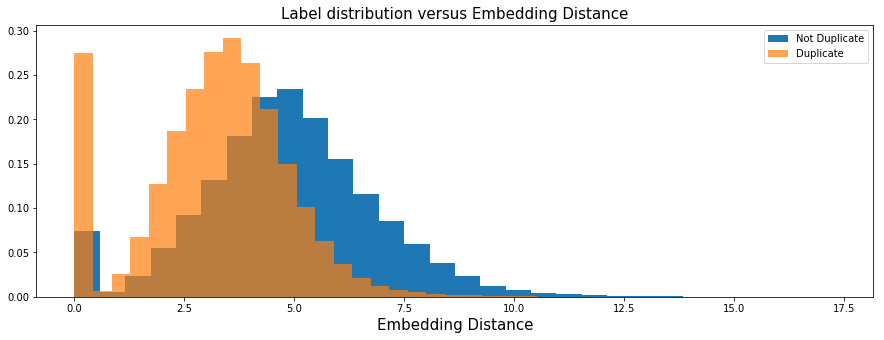

In [43]:
plt.figure(figsize=(15, 5))
plt.hist(train_balanced.loc[train_balanced["is_duplicate"] == 0, "emb_dist"], bins=30, normed=True, label='Not Duplicate')
plt.hist(train_balanced.loc[train_balanced["is_duplicate"] == 1, "emb_dist"], bins=30, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution versus Embedding Distance', fontsize=15)
plt.xlabel('Embedding Distance', fontsize=15)

In [53]:
features = train_balanced.columns[[7,8]]
features

Index(['random', 'emb_dist'], dtype='object')

In [54]:
y_train = train_balanced["is_duplicate"].values
x_train = train_balanced[features].values
y_val = val_balanced["is_duplicate"].values
x_val = val_balanced[features].values

In [55]:
import xgboost as xgb

xgb_pars = {"min_child_weight": 50, "eta": 0.05, "max_depth": 8,
            "subsample": 0.8, "silent" : 1, "nthread": 4,
            "eval_metric": "logloss", "objective": "binary:logistic"}

d_train = xgb.DMatrix(x_train, label=y_train)
d_val = xgb.DMatrix(x_val, label=y_val)

watchlist = [(d_train, 'train'), (d_val, 'valid')]

bst = xgb.train(xgb_pars, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=50)

[0]	train-logloss:0.669487	valid-logloss:0.669515
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.409801	valid-logloss:0.410984
[100]	train-logloss:0.404362	valid-logloss:0.406099
[150]	train-logloss:0.404049	valid-logloss:0.406046
[200]	train-logloss:0.403775	valid-logloss:0.406055
Stopping. Best iteration:
[167]	train-logloss:0.40393	valid-logloss:0.406045



In [47]:
x_train = x_train_q1 - x_train_q2
x_val = x_valid_q1 - x_valid_q2

In [52]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_val = xgb.DMatrix(x_val, label=y_val)

xgb_pars = {"min_child_weight": 50, "eta": 0.05, "max_depth": 8,
            "subsample": 0.8, "silent" : 1, "colsample_bytree": 0.3,
            "nthread": 4,
            "eval_metric": "logloss", "objective": "binary:logistic"}

watchlist = [(d_train, 'train'), (d_val, 'valid')]

bst = xgb.train(xgb_pars, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=50)

[0]	train-logloss:0.669799	valid-logloss:0.670009
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.394836	valid-logloss:0.400198
[100]	train-logloss:0.374619	valid-logloss:0.383555
[150]	train-logloss:0.36476	valid-logloss:0.37659
[200]	train-logloss:0.357382	valid-logloss:0.371904
[250]	train-logloss:0.351516	valid-logloss:0.368446
[300]	train-logloss:0.346622	valid-logloss:0.365708
[350]	train-logloss:0.342451	valid-logloss:0.363378


## References
* https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
* https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle/
* https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/